# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 9

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: strategy='uniform' в DummyClassifier генерирует предсказания равномерно случайным образом из списка уникальных классов, наблюдаемых в y, т.е. каждый класс имеет равную вероятность. Поэтому вероятность принадлежать пооложительному классу = 0.5, в y_random лежит вероятность

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


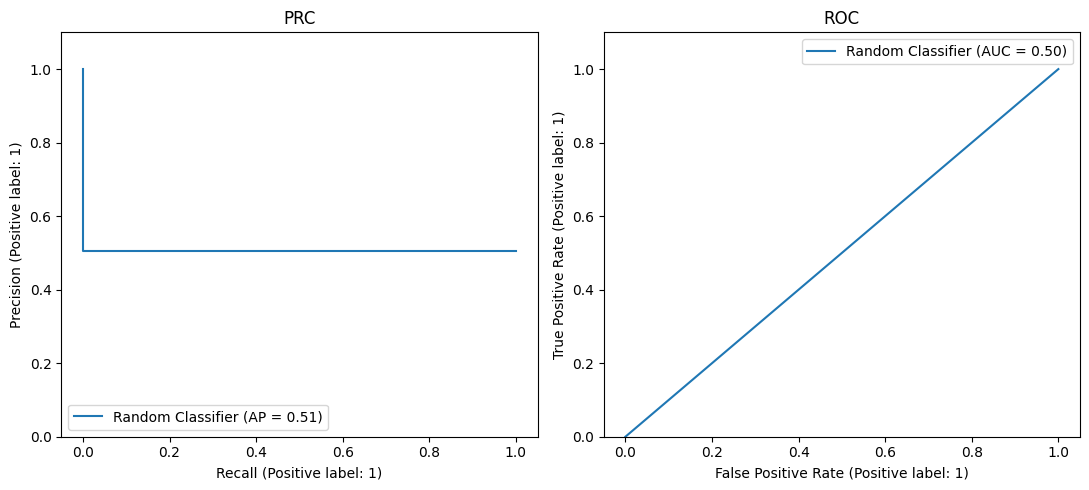

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#your code here

best_auc_pr = -10e9
best_c = 0

for c_ in np.logspace(-3, -0.5, 20):
    svc = LinearSVC(max_iter=100000, C=c_).fit(X_train, y_train)
    svc_pred = svc.predict(X_val)

    precision, recall, _ = precision_recall_curve(y_val, svc_pred)
    # print('AUC-PR: %.5f' % auc(recall, precision))
    cur_auc_pr = auc(recall, precision)
    if best_auc_pr < cur_auc_pr:
        best_c = c_
        best_auc_pr = cur_auc_pr

In [9]:
print('best_auc_pr: ', best_auc_pr, '\n', 'best_c: ', best_c)

best_auc_pr:  0.8272434486030229 
 best_c:  0.0018329807108324356


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

LinearSVC metrics
AUC-PR: 0.83262
AUC-ROC: 0.77333


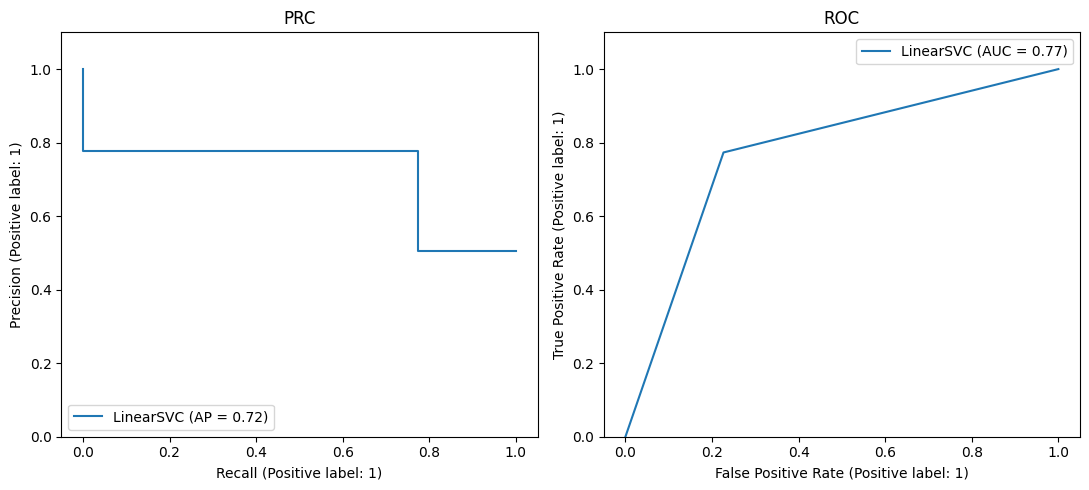

In [10]:
svc = LinearSVC(max_iter=100000, C=best_c).fit(X_train, y_train)
svc_pred = svc.predict(X_test)
depict_pr_roc(y_test, svc_pred, 'LinearSVC')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
df_metrics.loc['Linear SVC'] = [
      best_auc_pr,
      roc_auc_score(y_test, svc_pred),
      0
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
Linear SVC,0.827243,0.773334,0.0


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
#your code here

best_auc_pr_lr = -10e9
best_c_lr = 0

for c_ in np.logspace(1e-10, 3, 20):
    svc = LogisticRegression(C=c_).fit(X_train, y_train)
    svc_pred = svc.predict(X_val)

    precision, recall, _ = precision_recall_curve(y_val, svc_pred)
    # print('AUC-PR: %.5f' % auc(recall, precision))
    cur_auc_pr = auc(recall, precision)
    if best_auc_pr_lr < cur_auc_pr:
        best_c_lr = c_
        best_auc_pr_lr = cur_auc_pr

In [14]:
print('best_auc_pr: ', best_auc_pr_lr, '\n', 'best_c: ', best_c_lr)

best_auc_pr:  0.8275687162735844 
 best_c:  1.0000000002302585


LogisticRegression metrics
AUC-PR: 0.83299
AUC-ROC: 0.77396


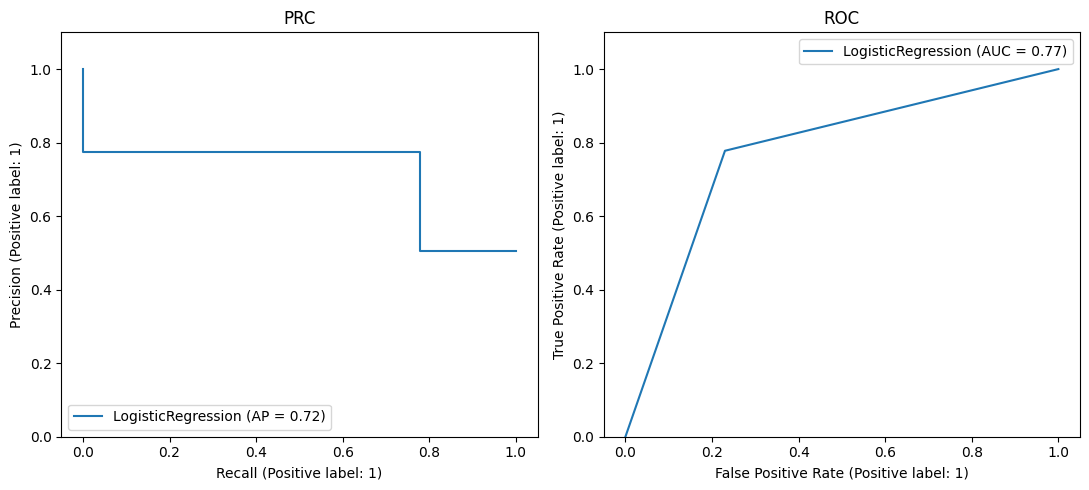

In [15]:
logistic_reg = LogisticRegression(C=best_c_lr).fit(X_train, y_train)
lr_pred = logistic_reg.predict(X_test)
depict_pr_roc(y_test, lr_pred, 'LogisticRegression')

In [16]:
df_metrics.loc['Logistic Regression'] = [
      best_auc_pr_lr,
      roc_auc_score(y_test, lr_pred),
      0
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
Linear SVC,0.827243,0.773334,0.0
Logistic Regression,0.827569,0.773956,0.0


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


LinearSVC metrics
AUC-PR: 0.83262
AUC-ROC: 0.77333


LogisticRegression metrics
AUC-PR: 0.83299
AUC-ROC: 0.77396


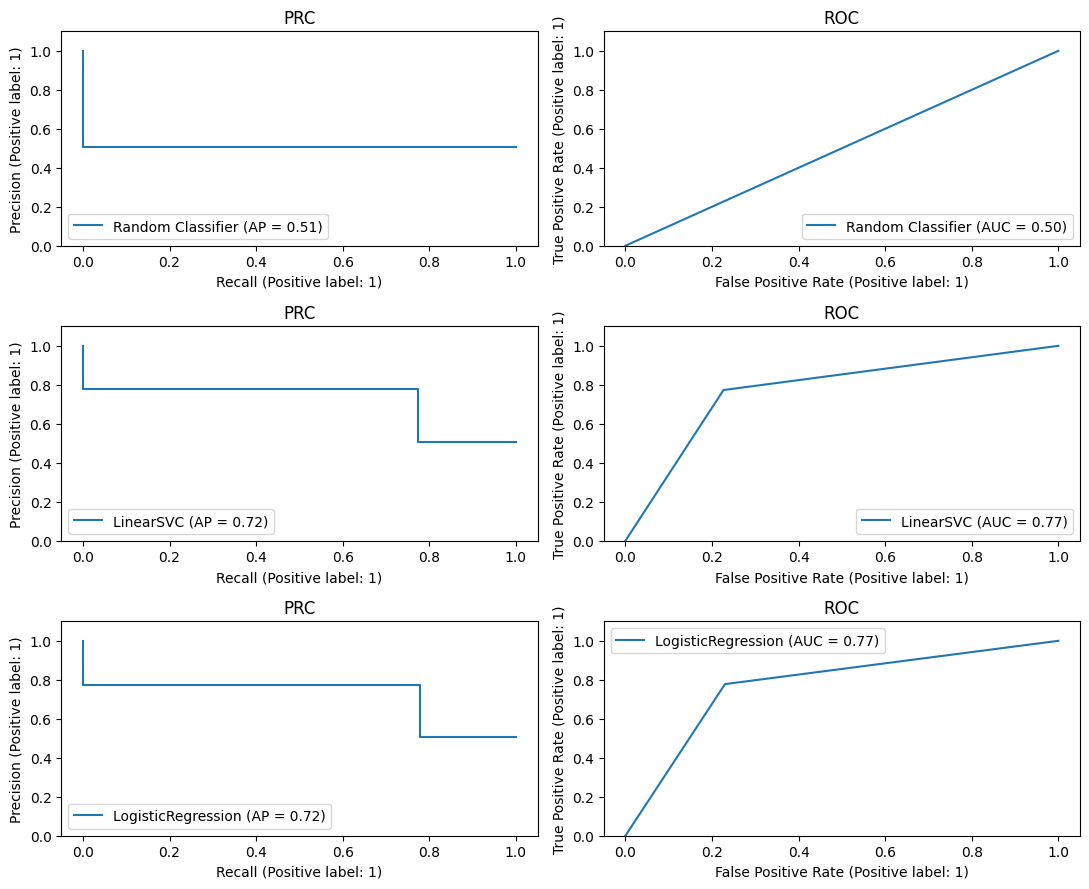

In [17]:
#your code here
fig, ax = plt.subplots(3, 2, figsize=(11, 9))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax = ax[0])

svc = LinearSVC(max_iter=100000, C=best_c).fit(X_train, y_train)
svc_pred = svc.predict(X_test)
depict_pr_roc(y_test, svc_pred, 'LinearSVC', ax = ax[1])


logistic_reg = LogisticRegression(C=best_c_lr).fit(X_train, y_train)
lr_pred = logistic_reg.predict(X_test)
depict_pr_roc(y_test, lr_pred, 'LogisticRegression', ax = ax[2])

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Различий между LR и SVM нет

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [18]:
from sklearn.svm import SVC

In [19]:
#your code here
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)


In [20]:
model_svc = SVC(kernel = 'linear',  C=best_c).fit(X, y)

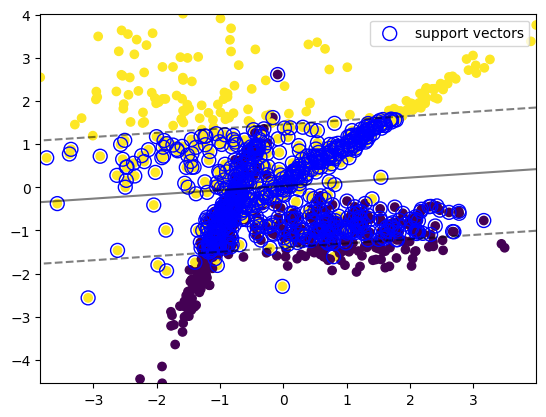

In [21]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y) #your code here)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model_svc)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Которые находятся ближе всего к разделяющей прямой

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [22]:
logistic_reg_model = LogisticRegression(C=best_c_lr).fit(X, y)

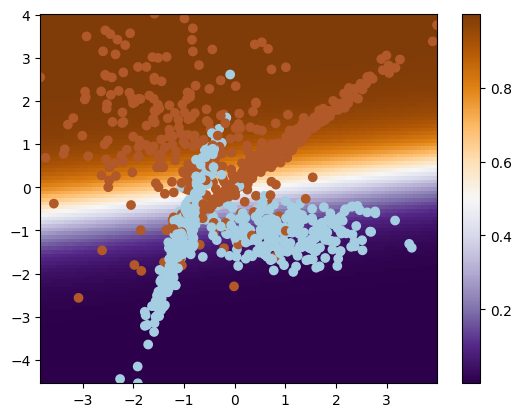

In [23]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]

    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, logistic_reg_model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:**  область, где модель не уверена - граница между двумя классами, в вероятность принадлежать классу 0.5. Модель не уверена потому что не знает к какому классу ее отнести

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [24]:
from pickle import NONE
def plot_calibration_curve(y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds[:, 1] >= l) & (preds[:, 1] <= r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label=name, color ='r')
    plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()


Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [25]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

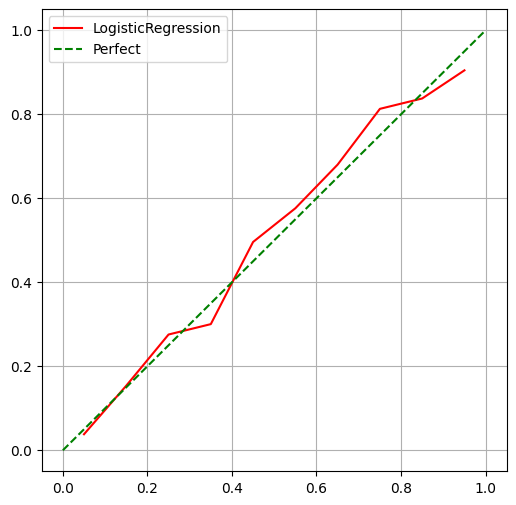

In [26]:
logistic_reg_model = LogisticRegression(C=best_c_lr).fit(X_train, y_train)
log_reg_pred = logistic_reg_model.predict_proba(X_test)
plot_calibration_curve(y_test, log_reg_pred, 'LogisticRegression')

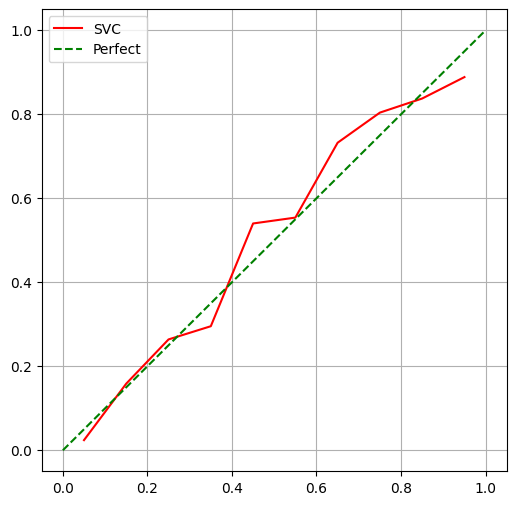

In [27]:
model_svc = SVC(kernel = 'linear',  C=best_c, probability=True).fit(X_train, y_train)
svc_pred = model_svc.predict_proba(X_test)
plot_calibration_curve(y_test, svc_pred, 'SVC')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Логистическая реграссия откалибровала лучше SVM

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

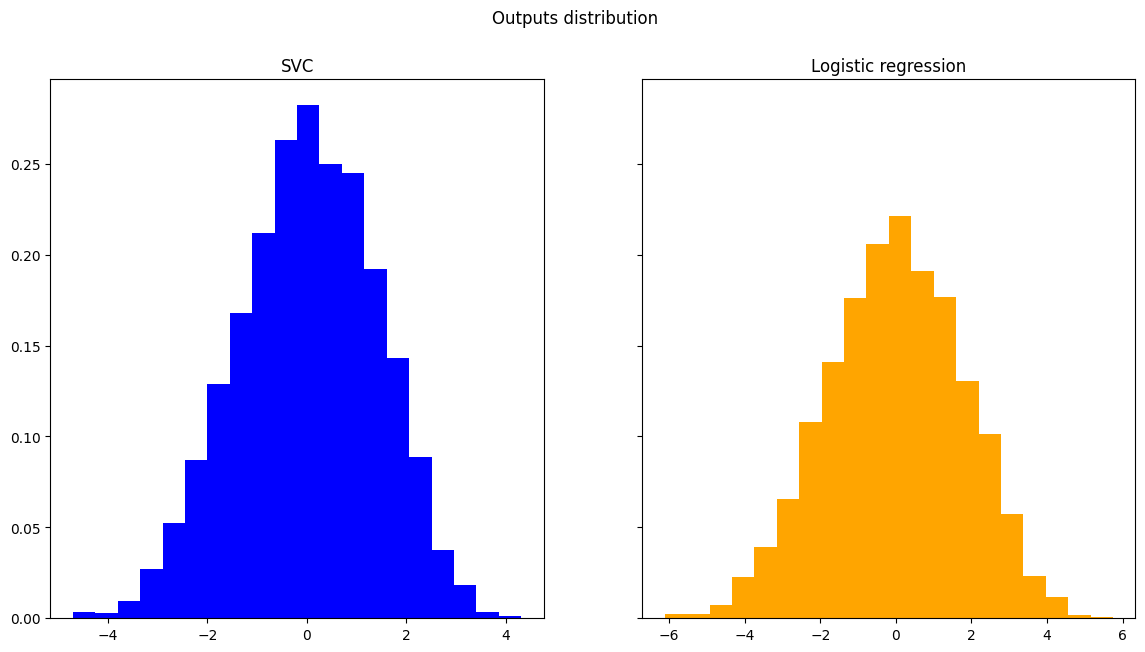

In [28]:
#your code here
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

axs[0].hist(model_svc.decision_function(X_test), bins=20, color='blue', density='True')
axs[1].hist(logistic_reg_model.decision_function(X_test), bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У логистической регрессии больше ответов, нежели у SVC. Воможно это связан с тем что SVC дает более точные прогнозы

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [29]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [30]:
#your code here
svc_calibrated = SVC(kernel='linear', C=best_c, probability=True)
calibrated_clf = CalibratedClassifierCV(svc_calibrated, cv=10).fit(X_train, y_train)
calibrated_pred = calibrated_clf.predict_proba(X_test)[:, 1]

model_svc = SVC(kernel = 'linear',  C=best_c, probability=True).fit(X_train, y_train)
svc_pred = model_svc.predict_proba(X_test)[:, 1]


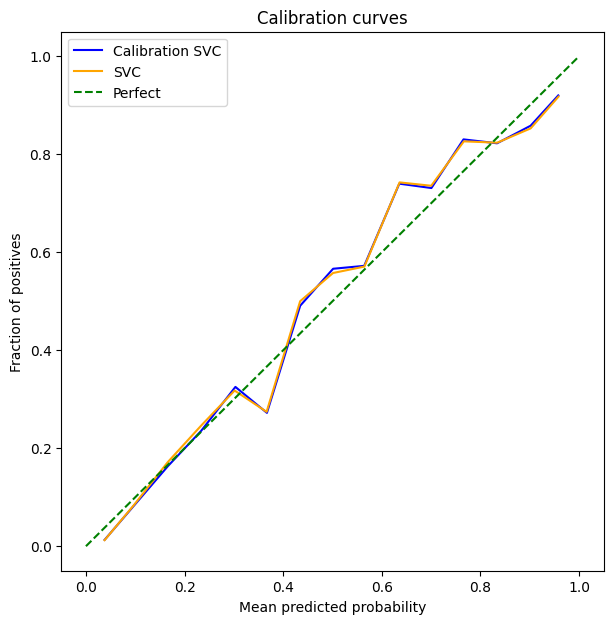

In [31]:
plt.figure(figsize=(7, 7))

svc_true_cal, svc_pred_cal = calibration_curve(y_test, calibrated_pred, n_bins=15)
svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)

plt.plot(svc_pred_cal, svc_true_cal, label='Calibration SVC', color='blue')
plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Почти не изменилась, поэтому не улучшилась

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [32]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
df = pd.read_csv('/content/drive/MyDrive/bike_buyers.csv')

In [35]:
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [36]:

#Заменим пропуски категориальных переменных
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',  'Region', 'Commute Distance']
numeric = ['Children', 'Age', 'Income', 'Cars']


values = dict.fromkeys(categorical, 'undefined')
df = df.fillna(value = values)

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = df[numeric]
X_categorical = df[categorical]

В начале поработаем только с категориальными признаками

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

In [39]:
#your code here


column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(), categorical),
    # ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])


t_start = time.time()
model_original = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OrdinalEncoder:', t_finish - t_start)

y_pred = model_original.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OrdinalEncoder: %.5f' % auc(recall, precision))


Time of work OrdinalEncoder: 0.01562643051147461
AUC-PR OrdinalEncoder: 0.62616


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [40]:
#your code here

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    # ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 0.0376436710357666
AUC-PR OneHotEncoder: 0.70489


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [41]:
def mean_target_encoder(X, y, categories):
    X_copy = X.copy()
    X_copy['Purchased Bike'] = y
    for column in categories:
        new_values = X_copy.groupby([column])['Purchased Bike'].mean().to_dict()
        X_copy[column].replace(new_values, inplace=True)
    X_copy.drop('Purchased Bike', axis = 1, inplace=True)
    return X_copy


In [42]:
#your code here

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(mean_target_encoder(X_train, y_train, categorical), y_train)
t_finish = time.time()

print('Time of work mean_target_encoder:', t_finish - t_start)

y_pred = model_onehot.predict(mean_target_encoder(X_test, y_test, categorical))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR mean_target_encoder: %.5f' % auc(recall, precision))

Time of work mean_target_encoder: 0.031281232833862305
AUC-PR mean_target_encoder: 0.72724


Время ухудшилось

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [43]:
#your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [44]:
def noise_encoder(X, y, categories):
    X_copy = X.copy()
    X_copy['Purchased Bike'] = y
    for column in categories:
        new_values = X_copy.groupby([column])['Purchased Bike'].mean().to_dict()
        X_copy[column].replace(new_values, inplace=True)
        X_copy[column] += np.random.normal(0, 0.1, len(X_copy[column]))
    X_copy.drop('Purchased Bike', axis = 1, inplace=True)
    return X_copy

In [45]:
#your code here
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(noise_encoder(X_train, y_train, categorical), y_train)
t_finish = time.time()

print('Time of work noise_encoder:', t_finish - t_start)

y_pred = model_onehot.predict(noise_encoder(X_test, y_test, categorical))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR noise_encoder: %.5f' % auc(recall, precision))

Time of work noise_encoder: 0.029837846755981445
AUC-PR noise_encoder: 0.65990


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Нет, не помогло. Время стало лучше , а AUC-PR нет.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [46]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [47]:
def smoothing(x, global_mean, c):

    return (x.sum() + c*global_mean)/(x.sum() + c)


In [48]:
def smoothing_encoder(X, y, categories):
    X_copy = X.copy()
    X_copy['Purchased Bike'] = y

    global_mean = y.mean()
    c = 6

    for column in categories:
        new_values = X_copy.groupby([column])['Purchased Bike'].agg(lambda x: smoothing(x, global_mean, c)).to_dict()
        X_copy[column].replace(new_values, inplace=True)
    X_copy.drop('Purchased Bike', axis = 1, inplace=True)
    return X_copy

In [49]:
#your code here
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(smoothing_encoder(X_train, y_train, categorical), y_train)
t_finish = time.time()

print('Time of work smoothing_encoder:', t_finish - t_start)

y_pred = model_onehot.predict(smoothing_encoder(X_test, y_test, categorical))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR smoothing_encoder: %.5f' % auc(recall, precision))

Time of work smoothing_encoder: 0.04926419258117676
AUC-PR smoothing_encoder: 0.74000


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [50]:
#your code here
for category in numeric:
    df = df.fillna({category : df[category].mean()})

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df[numeric], y, test_size=0.25, random_state=777, stratify=y)

In [52]:
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(mean_target_encoder(X_train, y_train, numeric), y_train)
t_finish = time.time()

print('Encoding:', *numeric)
print('Time of work mean_target_encoder:', t_finish - t_start)

y_pred = model_onehot.predict(mean_target_encoder(X_test, y_test, numeric))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR mean_target_encoder: %.5f' % auc(recall, precision))

Encoding: Children Age Income Cars
Time of work mean_target_encoder: 0.017197847366333008
AUC-PR mean_target_encoder: 0.77793


In [53]:
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(mean_target_encoder(X_train, y_train, [numeric[0]]), y_train)
t_finish = time.time()

print('Encoding:', numeric[0])

print('Time of work mean_target_encoder:', t_finish - t_start)

y_pred = model_onehot.predict(mean_target_encoder(X_test, y_test, [numeric[0]]))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR mean_target_encoder: %.5f' % auc(recall, precision))

Encoding: Children
Time of work mean_target_encoder: 0.01585841178894043
AUC-PR mean_target_encoder: 0.58573


In [54]:
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(mean_target_encoder(X_train, y_train, [numeric[1]]), y_train)
t_finish = time.time()

print('Encoding:', numeric[1])

print('Time of work mean_target_encoder:', t_finish - t_start)

y_pred = model_onehot.predict(mean_target_encoder(X_test, y_test, [numeric[1]]))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR mean_target_encoder: %.5f' % auc(recall, precision))

Encoding: Age
Time of work mean_target_encoder: 0.014518260955810547
AUC-PR mean_target_encoder: 0.74000


In [55]:
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(mean_target_encoder(X_train, y_train, [numeric[2]]), y_train)
t_finish = time.time()

print('Encoding:', numeric[2])

print('Time of work mean_target_encoder:', t_finish - t_start)

y_pred = model_onehot.predict(mean_target_encoder(X_test, y_test, [numeric[2]]))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR mean_target_encoder: %.5f' % auc(recall, precision))

Encoding: Income
Time of work mean_target_encoder: 0.03155183792114258
AUC-PR mean_target_encoder: 0.74018


In [56]:
pipeline = Pipeline(steps=[
    ('regression', LogisticRegression())
])


t_start = time.time()
model_onehot = pipeline.fit(mean_target_encoder(X_train, y_train, [numeric[3]]), y_train)
t_finish = time.time()

print('Encoding:', numeric[3])

print('Time of work mean_target_encoder:', t_finish - t_start)

y_pred = model_onehot.predict(mean_target_encoder(X_test, y_test, [numeric[3]]))

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR mean_target_encoder: %.5f' % auc(recall, precision))

Encoding: Cars
Time of work mean_target_encoder: 0.016222715377807617
AUC-PR mean_target_encoder: 0.58573




Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ С счетчиками лучше метрика, но работает дольше

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [57]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 20:16:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [  <=>               ]   3.79M  9.58MB/s    in 0.4s    

2023-11-22 20:16:53 (9.58 MB/s) - ‘adult.data’ saved [3974305]



In [58]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
13666,37,Private,365465,HS-grad,9,Separated,Craft-repair,Unmarried,White,Male,0,0,70,Philippines,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [59]:
#your code here
y = df['income']
X = df.drop(columns=['income'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [60]:
#your code here
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', ]

In [61]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

column_transformer.fit(X_train, y_train)

print('До кодировки:', X_train.shape[1])
print('После кодировки:', column_transformer.transform(X_train).shape[1])

До кодировки: 14
После кодировки: 107


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [62]:
#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000))
])


t_start = time.time()
model_onehot = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 1.1849350929260254
AUC-PR OneHotEncoder: 0.71864


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [63]:
from sklearn.feature_selection import SelectFromModel



In [64]:
#your code here

selector = SelectFromModel(model_onehot.named_steps['regression'], max_features=40)
selector.fit(column_transformer.transform(X_train), y_train)

selected = model_onehot.named_steps['ohe_and_scaling'].get_feature_names_out()[selector.get_support()]

selected

array(['ohe__workclass_ Federal-gov', 'ohe__workclass_ Without-pay',
       'ohe__education_ 1st-4th', 'ohe__education_ 5th-6th',
       'ohe__education_ Preschool', 'ohe__marital-status_ Divorced',
       'ohe__marital-status_ Married-AF-spouse',
       'ohe__marital-status_ Married-civ-spouse',
       'ohe__marital-status_ Married-spouse-absent',
       'ohe__marital-status_ Never-married',
       'ohe__marital-status_ Separated',
       'ohe__occupation_ Exec-managerial',
       'ohe__occupation_ Farming-fishing',
       'ohe__occupation_ Other-service',
       'ohe__occupation_ Priv-house-serv',
       'ohe__occupation_ Prof-specialty',
       'ohe__occupation_ Protective-serv',
       'ohe__occupation_ Tech-support',
       'ohe__relationship_ Other-relative',
       'ohe__relationship_ Own-child', 'ohe__relationship_ Wife',
       'ohe__sex_ Female', 'ohe__native-country_ Cambodia',
       'ohe__native-country_ Canada', 'ohe__native-country_ Columbia',
       'ohe__native-country

In [65]:
#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('selector', selector),
    ('regression', LogisticRegression(max_iter=10000))

])


t_start = time.time()
model_onehot = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 1.6046700477600098
AUC-PR OneHotEncoder: 0.69741


Изменилось ли качество? Как?

Качество немного упало и время больше

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [66]:
#your code here

#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000))
])


t_start = time.time()
model_onehot = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 0.6413381099700928
AUC-PR OneHotEncoder: 0.67482


In [67]:
threshold = np.sort(np.abs(model_onehot.named_steps['regression'].coef_[0]))[-40]
selector = SelectFromModel(model_onehot.named_steps['regression'], threshold=threshold)
selector.fit(column_transformer.transform(X_train), y_train)


SelectFromModel(estimator=LogisticRegression(max_iter=10000),
                threshold=0.5604799072724903)

In [68]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('selector', selector),
    ('regression', LogisticRegression(max_iter=10000))

])


t_start = time.time()
model_onehot = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 1.4756367206573486
AUC-PR OneHotEncoder: 0.69635


Качество улучшилось, время стало больше

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [69]:
#your code here

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000))
])
X_train_encoded = column_transformer.fit_transform(X_train)
X_test_encoded = column_transformer.transform(X_test)

scaler = StandardScaler()

X_train_encoded = scaler.fit_transform(pd.DataFrame(X_train_encoded.toarray()))
X_test_encoded = scaler.fit_transform(pd.DataFrame(X_test_encoded.toarray()))


model_onehot = LogisticRegression(max_iter=10000)

t_start = time.time()
model_onehot.fit(X_train_encoded, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test_encoded)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 1.505753993988037
AUC-PR OneHotEncoder: 0.71847


In [70]:
threshold = np.sort(np.abs(model_onehot.coef_[0]))[-40]
selector = SelectFromModel(model_onehot, threshold=threshold)
selector.fit(column_transformer.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(max_iter=10000),
                threshold=0.08537162041827401)

In [71]:
column_transformer.get_feature_names_out()[selector.get_support()]

array(['ohe__workclass_ Federal-gov', 'ohe__workclass_ Never-worked',
       'ohe__workclass_ Private', 'ohe__workclass_ Self-emp-inc',
       'ohe__workclass_ Self-emp-not-inc', 'ohe__workclass_ Without-pay',
       'ohe__education_ 11th', 'ohe__education_ 1st-4th',
       'ohe__education_ 5th-6th', 'ohe__education_ 7th-8th',
       'ohe__education_ Assoc-acdm', 'ohe__education_ Assoc-voc',
       'ohe__education_ Doctorate', 'ohe__education_ Preschool',
       'ohe__education_ Prof-school', 'ohe__marital-status_ Divorced',
       'ohe__marital-status_ Married-AF-spouse',
       'ohe__marital-status_ Married-civ-spouse',
       'ohe__marital-status_ Married-spouse-absent',
       'ohe__marital-status_ Never-married',
       'ohe__marital-status_ Separated', 'ohe__marital-status_ Widowed',
       'ohe__occupation_ ?', 'ohe__occupation_ Adm-clerical',
       'ohe__occupation_ Armed-Forces', 'ohe__occupation_ Craft-repair',
       'ohe__occupation_ Exec-managerial',
       'ohe__occupati

In [72]:
#your code here

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000))
])
X_train_encoded = column_transformer.fit_transform(X_train)
X_test_encoded = column_transformer.transform(X_test)

scaler = StandardScaler()

X_train_encoded = scaler.fit_transform(X_train_encoded.toarray())
X_test_encoded = scaler.fit_transform(X_test_encoded.toarray())
X_train_encoded = selector.transform(X_train_encoded)
X_test_encoded = selector.transform(X_test_encoded)



model_onehot = LogisticRegression(max_iter=10000)

t_start = time.time()
model_onehot.fit(X_train_encoded, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test_encoded)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 0.4513840675354004
AUC-PR OneHotEncoder: 0.72000


Качество улучшилось

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [73]:
#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000))
])


t_start = time.time()
model_onehot = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 0.7858884334564209
AUC-PR OneHotEncoder: 0.71864


In [74]:
from sklearn.feature_selection import SelectKBest, f_classif

In [75]:
selector = SelectKBest(f_classif, k=40)
selector.fit(column_transformer.transform(X_train), y_train)
selected = model_onehot.named_steps['ohe_and_scaling'].get_feature_names_out()[selector.get_support()]

selected

array(['ohe__workclass_ ?', 'ohe__workclass_ Federal-gov',
       'ohe__workclass_ Private', 'ohe__workclass_ Self-emp-inc',
       'ohe__education_ 10th', 'ohe__education_ 11th',
       'ohe__education_ Bachelors', 'ohe__education_ Doctorate',
       'ohe__education_ HS-grad', 'ohe__education_ Masters',
       'ohe__education_ Prof-school', 'ohe__education_ Some-college',
       'ohe__marital-status_ Divorced',
       'ohe__marital-status_ Married-civ-spouse',
       'ohe__marital-status_ Never-married',
       'ohe__marital-status_ Separated', 'ohe__marital-status_ Widowed',
       'ohe__occupation_ ?', 'ohe__occupation_ Adm-clerical',
       'ohe__occupation_ Exec-managerial',
       'ohe__occupation_ Handlers-cleaners',
       'ohe__occupation_ Machine-op-inspct',
       'ohe__occupation_ Other-service',
       'ohe__occupation_ Prof-specialty', 'ohe__relationship_ Husband',
       'ohe__relationship_ Not-in-family',
       'ohe__relationship_ Other-relative',
       'ohe__relation

In [76]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('selector', selector),
    ('regression', LogisticRegression(max_iter=10000))
])


t_start = time.time()
model_onehot = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 0.4910759925842285
AUC-PR OneHotEncoder: 0.70634


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [77]:
#your code here

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000))
])


t_start = time.time()
model_onehot = pipeline.fit(X_train, y_train)
t_finish = time.time()

print('Time of work OneHotEncoder:', t_finish - t_start)

y_pred = model_onehot.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR OneHotEncoder: %.5f' % auc(recall, precision))

Time of work OneHotEncoder: 0.7672147750854492
AUC-PR OneHotEncoder: 0.71864


In [78]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

In [79]:
cut_len = X_train.shape[0]//10 # так как считает больше 40 мин, если не обрезать
X_train_c, X_val, y_train_c, y_val = train_test_split(X_train[:cut_len], y_train[:cut_len], test_size=0.2, random_state=777, stratify=y_train[:cut_len])

X_train_encoded = column_transformer.fit_transform(X_train_c).toarray()
X_val_encoded = column_transformer.transform(X_val).toarray()

selected = np.ones(X_train_encoded.shape[1])

for i in range(X_train_encoded.shape[1], 39, -1):
    best_auc_pr = -1
    cur_select = selected.copy()
    for j in range(X_train_encoded.shape[1]):
        if cur_select[j]:
            cur_select[j] = 0

            cur_model = LogisticRegression(max_iter=1000).fit(X_train_encoded[:, cur_select == 1], y_train_c)
            y_pred = cur_model.predict(X_val_encoded[:, cur_select == 1])

            precision, recall, _ = precision_recall_curve(y_val, y_pred)
            cur_auc_pr = auc(recall, precision)
            if best_auc_pr < cur_auc_pr:
                selected = cur_select.copy()
                best_auc_pr = cur_auc_pr
            cur_select[j] = 1



best_model = LogisticRegression(max_iter=1000)
t_start = time.time()

best_model.fit(column_transformer.fit_transform(X_train)[:, selected == 1], y_train)

t_finish = time.time()

print('Time of work best_model:', t_finish - t_start)

y_pred = best_model.predict(column_transformer.transform(X_test)[:, selected == 1])

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR best_model: %.5f' % auc(recall, precision))



Time of work best_model: 0.27184057235717773
AUC-PR best_model: 0.65566


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [80]:
cut_len = X_train.shape[0]//10 # так как считает больше 40 мин, если не обрезать
X_train_c, X_val, y_train_c, y_val = train_test_split(X_train[:cut_len], y_train[:cut_len], test_size=0.2, random_state=777, stratify=y_train[:cut_len])

X_train_encoded = column_transformer.fit_transform(X_train_c).toarray()
X_val_encoded = column_transformer.transform(X_val).toarray()

selected = np.ones(X_train_encoded.shape[1])

for i in range(X_train_encoded.shape[1], 39, -1):
    best_auc_pr = -1
    cur_select = selected.copy()
    for j in range(X_train_encoded.shape[1]):
        if not cur_select[j]:
            cur_select[j] = 1

            cur_model = LogisticRegression(max_iter=1000).fit(X_train_encoded[:, cur_select == 1], y_train_c)
            y_pred = cur_model.predict(X_val_encoded[:, cur_select == 1])

            precision, recall, _ = precision_recall_curve(y_val, y_pred)
            cur_auc_pr = auc(recall, precision)
            if best_auc_pr < cur_auc_pr:
                selected = cur_select.copy()
                best_auc_pr = cur_auc_pr
            cur_select[j] = 0



best_model = LogisticRegression(max_iter=1000)
t_start = time.time()

best_model.fit(column_transformer.fit_transform(X_train)[:, selected == 1], y_train)

t_finish = time.time()

print('Time of work best_model:', t_finish - t_start)

y_pred = best_model.predict(column_transformer.transform(X_test)[:, selected == 1])

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR best_model: %.5f' % auc(recall, precision))



Time of work best_model: 0.41527700424194336
AUC-PR best_model: 0.67408


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Лучше метод оказался второй, у него лучше метрика, но он медленнее. По второму методу быстрее подобрать признаки из-за количества итераций

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [81]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-22 20:23:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.79MB/s    in 0.2s    

2023-11-22 20:23:04 (1.79 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [82]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [83]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [84]:
from sklearn.model_selection import cross_val_score, KFold


In [85]:
# your code here

categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000))
])

kfold = KFold(n_splits=5, shuffle=True, random_state=500)
scores = cross_val_score(pipeline, X, y, cv=kfold)
print(scores)

[0.90361738 0.89973294 0.89694101 0.90749059 0.89073692]


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [86]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=10000))
])

In [87]:
# your code here

predictions = np.zeros(len(y))

for i, (train_index, test_index) in enumerate(kfold.split(X)):
    model_onehot = pipeline.fit(X.loc[train_index], y[train_index])

    y_pred = model_onehot.predict(X.loc[test_index])
    predictions[test_index] = y_pred

    precision, recall, _ = precision_recall_curve(y[test_index], y_pred)
    print('AUC-PR : %.5f' % auc(recall, precision))

AUC-PR : 0.52443
AUC-PR : 0.47753
AUC-PR : 0.47238
AUC-PR : 0.50834
AUC-PR : 0.45327


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [88]:
# your code here

erned = np.zeros(5)
wasted = np.zeros(5)

for i, (train_index, test_index) in enumerate(kfold.split(X)):
    erned[i] = 10 * y[test_index][predictions[test_index] == 1].sum()
    wasted[i] = predictions[test_index].sum()

print('Выручка: ', erned)
print('Отдали на зп: ', wasted)
print('Средняя зп: ', np.mean(wasted))

print('Средняя выручка: ', np.mean(erned))
print('Стандартное отклонение выручки: ', np.std(erned))
print('Средний заработок: ', np.mean(erned - wasted))



Выручка:  [2240. 2110. 2090. 2250. 1960.]
Отдали на зп:  [310. 330. 330. 330. 321.]
Средняя зп:  324.2
Средняя выручка:  2130.0
Стандартное отклонение выручки:  107.144761887831
Средний заработок:  1805.8


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [89]:
#your code here

erned = np.zeros(5)
wasted = np.zeros(5)

for i, (train_index, test_index) in enumerate(kfold.split(X)):

    agreed = np.array(y[test_index][predictions[test_index] == 1])
    erned[i] = sum(np.random.uniform(20, size=len(agreed)) * agreed)
    wasted[i] = predictions[test_index].sum()

print('Выручка: ', erned)
print('Отдали на зп: ', wasted)
print('Средняя зп: ', np.mean(wasted))

print('Средняя выручка: ', np.mean(erned))
print('Стандартное отклонение выручки: ', np.std(erned))
print('Средний заработок: ', np.mean(erned - wasted))

Выручка:  [2377.51649465 2198.94511343 2138.37832267 2374.49449435 2117.5606416 ]
Отдали на зп:  [310. 330. 330. 330. 321.]
Средняя зп:  324.2
Средняя выручка:  2241.3790133416105
Стандартное отклонение выручки:  113.13170415151903
Средний заработок:  1917.1790133416114


Средняя выручка выросла, но отклонение увеличилось

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [90]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

def get_pipeline(coef):
    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(max_iter=10000, C = coef, random_state = 777))
    ])
    return pipeline

In [91]:
kfold = KFold(n_splits=5, shuffle=True, random_state=500)
best_coef = 0
best_profit = 0

coefs = np.logspace(-3, -0.5, 5)
profits = []
stds = []

for coef_ in coefs:
  erned = np.zeros(5)
  wasted = np.zeros(5)
  for i, (train_index, test_index) in enumerate(kfold.split(X)):
      model_onehot = get_pipeline(coef_).fit(X.loc[train_index], y[train_index])

      y_pred = model_onehot.predict(X.loc[test_index])
      predictions[test_index] = y_pred


      agreed = y[test_index][predictions[test_index] == 1]
      erned[i] = sum(np.random.uniform(20, size=len(agreed)) * agreed)
      wasted[i] = predictions[test_index].sum()

  profits.append(np.mean(erned - wasted))
  stds.append(np.std(erned - wasted))
  if profits[-1] > best_profit:
     best_coef = coef_
     best_profit = profits[-1]


print('Средняя прибыль:', profits)
print('Отклонения:', stds)
print('Лучший коэффициент:', best_coef)

Средняя прибыль: [1536.677507528293, 1722.4493968736515, 1863.2822261906072, 1915.9623410180852, 1899.4640402306]
Отклонения: [145.39428440769188, 102.43184068060272, 142.98549085871363, 78.41281030984959, 91.75210646289624]
Лучший коэффициент: 0.07498942093324558


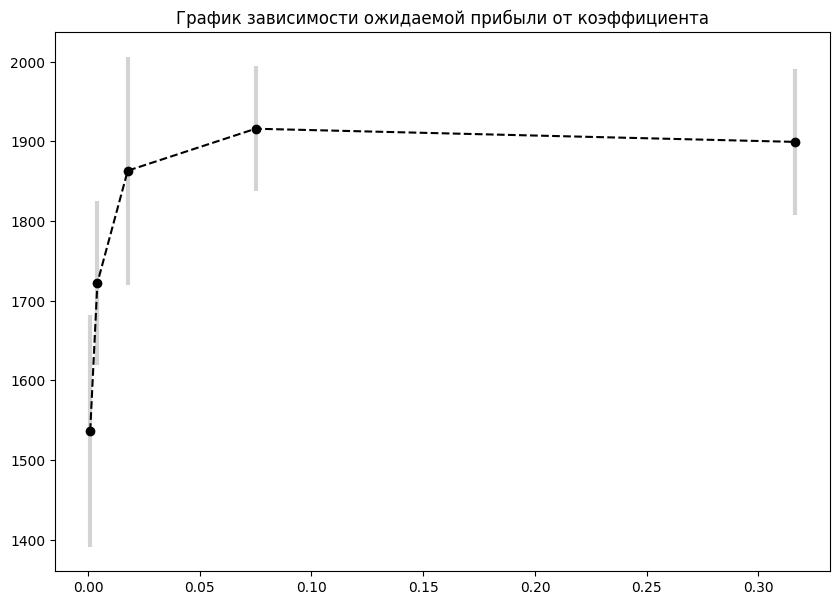

In [92]:
plt.figure(figsize=(10, 7))
plt.errorbar(coefs, profits, yerr=stds, fmt='o', color='black', linestyle = '--',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.title('График зависимости ожидаемой прибыли от коэффициента')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Средняя прибыль: [1581.6649418403542, 1650.3720337548682, 1835.57367159118, 1842.3836738617279, 1940.1757542323478]
Отклонения: [119.13819618919327, 152.56840431010008, 153.66960587645983, 129.86260233205542, 112.24162433658189]
Лучший коэффициент: 0.31622776601683794
------------------------------
Средняя прибыль: [1564.26416919855, 1714.148946104107, 1775.9827051142966, 1835.0987174524294, 1909.1147103306812]
Отклонения: [127.70899277596932, 107.19344974804812, 121.25491760169236, 102.40501853656932, 88.25054266998079]
Лучший коэффициент: 0.31622776601683794
------------------------------
Средняя прибыль: [1617.0313650095238, 1620.6289159993971, 1841.6638094398295, 1876.8532330598252, 1928.337731611307]
Отклонения: [133.2077190314332, 117.29810135904327, 123.78232852294158, 93.2705728503131, 157.19346220581247]
Лучший коэффициент: 0.31622776601683794
------------------------------
Средняя прибыль: [1621.2290457431877, 1641.162511641241, 1820.4922835649354, 1923.2716477715664, 1918.30

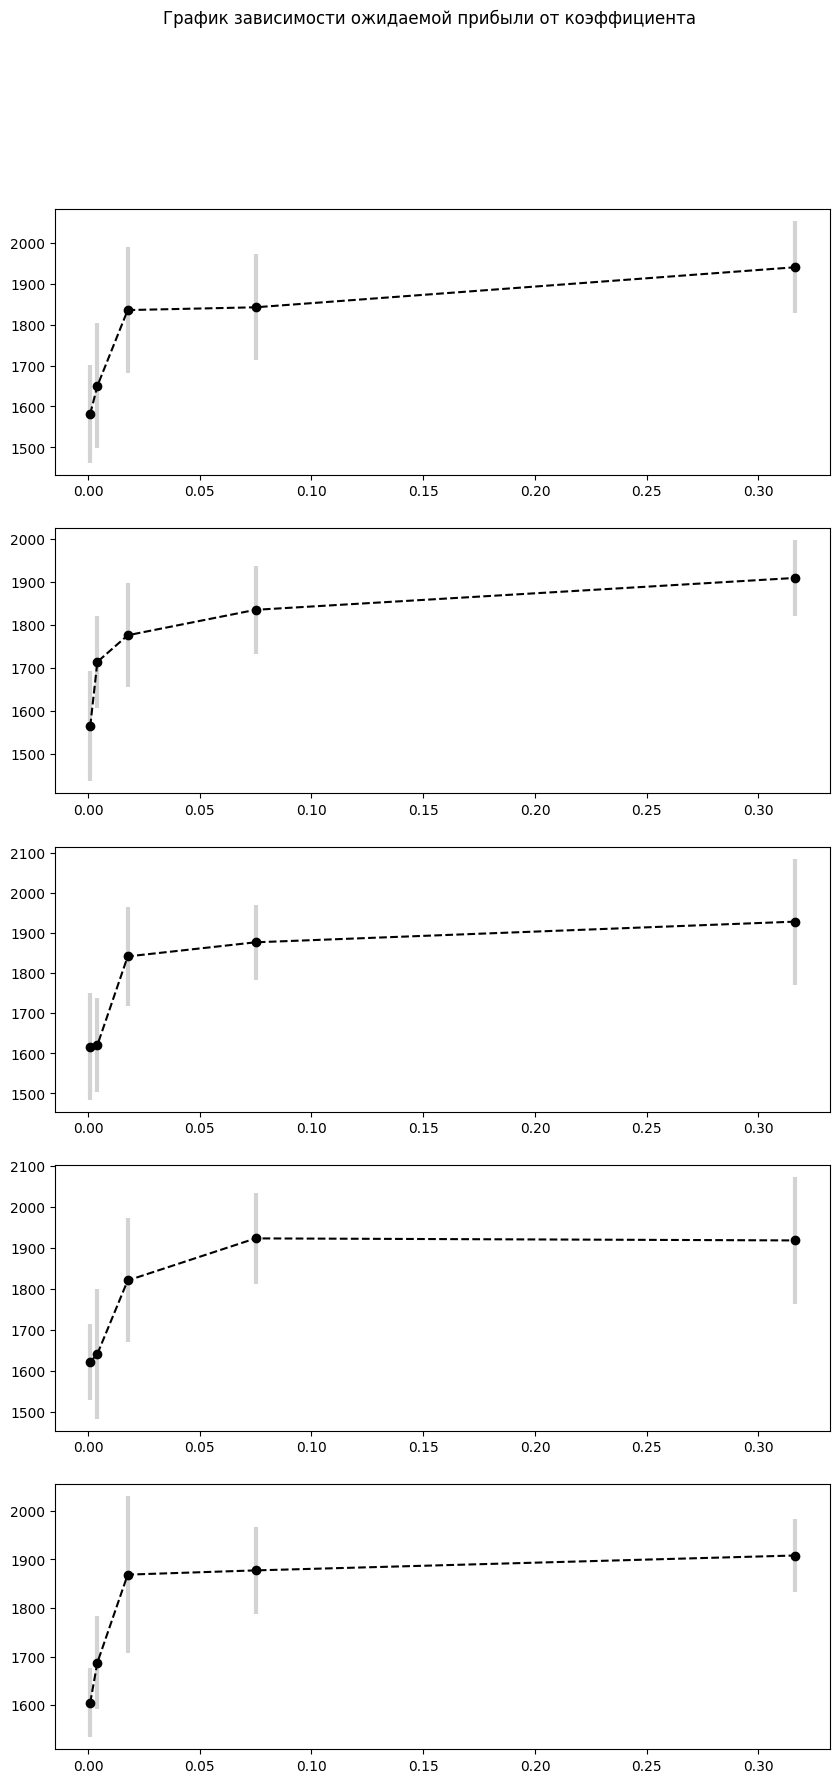

In [93]:
#your code here

fig, ax = plt.subplots(5, 1, figsize=(10, 20))
for j in range(5):
    kfold = KFold(n_splits=5, shuffle=True, random_state=500)
    best_coef = 0
    best_profit = 0

    coefs = np.logspace(-3, -0.5, 5)
    profits = []
    stds = []

    for coef_ in coefs:
      erned = np.zeros(5)
      wasted = np.zeros(5)
      for i, (train_index, test_index) in enumerate(kfold.split(X)):
          model_onehot = get_pipeline(coef_).fit(X.loc[train_index], y[train_index])

          y_pred = model_onehot.predict(X.loc[test_index])
          predictions[test_index] = y_pred


          agreed = y[test_index][predictions[test_index] == 1]
          erned[i] = sum(np.random.uniform(20, size=len(agreed)) * agreed)
          wasted[i] = predictions[test_index].sum()

      profits.append(np.mean(erned - wasted))
      stds.append(np.std(erned - wasted))
      if profits[-1] > best_profit:
         best_coef = coef_
         best_profit = profits[-1]


    print('Средняя прибыль:', profits)
    print('Отклонения:', stds)
    print('Лучший коэффициент:', best_coef)
    print('------------------------------')

    ax[j].errorbar(coefs, profits, yerr=stds, fmt='o', color='black', linestyle = '--',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.suptitle('График зависимости ожидаемой прибыли от коэффициента')
plt.show()

In [96]:
best_coef_c = 0.31622776601683794

Графики получились похожими, так же лучший коэффициент:  0.31622776601683794, он повторяется 4 из 5 раз

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # recall важнее так как если модель имеет высокий recall, то она будет правильно определять большое количество потенциальных клиентов, которые ответят положительно на предложение. Если модель имеет высокий precision, то тогда звонков будет меньше, но это может привести к упущенной прибыли от потенциальных клиентов, которых модель не определила



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here